## Imports

In [1]:
import time
import math
import random
from numba import jit, njit, prange
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

In [2]:
@njit(parallel=True)
def f(x):
    return x**4

@njit(parallel=True)
def f_prime(x):
    return 4*x**3

@njit(parallel=True)
def f_second(x):
    return 4*3*x**2

@njit(parallel=True)
def forward(f,x,h):
    return (f(x+h) - f(x))/h

@njit(parallel=True)
def backward(f,x,h):
    return (f(x) - f(x-h))/h

@njit(parallel=True)
def midpoint(f,x,h):
    return (f(x+h) - f(x-h))/(2*h)

@njit(parallel=True)
def error(f, x, h, ana, num):
    return np.abs( (num(f,x,h) - ana(x))/ana(x) )

@njit(parallel=True)
def error_exact(f, x, h, ana, num):
    return np.abs( (num(f,x,h) - ana)/ana )

In [3]:
x = 1.4
h = np.logspace(-9, 1, 1e5)

In [4]:
methods = (forward, backward, midpoint)
labels = ('forward','backward','midpoint')

In [5]:
errors = []
for method in tqdm(methods):
    err = error(f, x, h, ana=f_prime, num=method)
    errors.append(err)

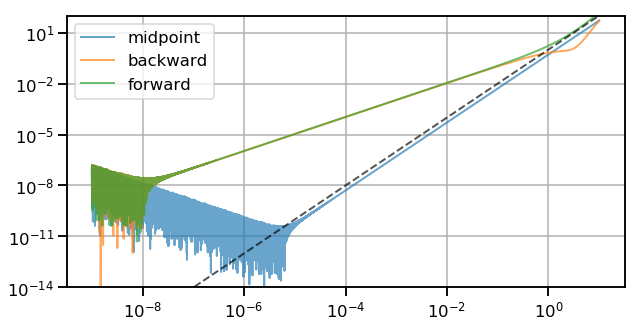

In [7]:
sns.set_context("talk", rc={"lines.linewidth": 2})
fig, ax = plt.subplots(1,1, figsize=(10, 5), sharex=True, sharey=True)

for err, lab in zip( errors[::-1], labels[::-1] ):
    ax.plot(h, err, label=lab, alpha=.67)

ax.plot(h, h**2, ls='--', c='black', alpha=.67)
# ax.plot(h, h**(3/2), ls='--', c='black', alpha=.67)
# for err, lab in zip( errors_exact, labels ):
#     ax.plot(h, err, label=lab+' exact', alpha=.2, linestyle='--', color='black')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylim(1e-14,1e2)
plt.legend()
plt.grid()
plt.show()

In [8]:
del err, error, errors, h

# Exercise 2

Langevin equations describing a free Brownian Motion:

$\epsilon(t)$ is white noise, D is the diffusion constant

$\langle \epsilon(t) \rangle = 0$

$\langle\epsilon(t)\epsilon(t')\rangle  = 2Dδ(t − t' )$

Assuming that the mass m = 1, the friction constant γ = 1 and the temperature T = 1,
simulate the two processes with a fixed initial position and the physical initial condition
for the velocity.

$D = \mu k_B T = \frac{1}{\gamma} k_B T = 1$ 

## Imports

In [5]:
import time
import math
import random
from numba import jit, njit, prange
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Constants

In [6]:
t      = 10                     # end time
dt     = 1e-4                   # time step
Steps  = int(t/dt)              # number of steps
pi     = np.pi                  # pi
tsteps = np.linspace(0,t,Steps)
gamma  = 1. 
mu     = 1/gamma                # inverse friction coefficient = mobility of particle
kB     = 1.                     # Boltzmann's Constant
T      = 1.                     # Temperature
m      = 1.                     # mass of particle
D      = mu*kB*T                # Diffusion Coefficient
 
x      = 0.                     # current position
Mean   = 0.                     # mean of W_t
Var    = np.sqrt(2*D*dt)        # Variance of W_t
# k     = 1.                    # force constant of harmonic potential

NumOfTrajs = int(2e3)          # How many trajectories

## Overdamped
$ \dot x(t) = \epsilon(t) $

Discretized:

$ x(t + dt) = x(t) + \epsilon(t)$

In [7]:
@jit(nopython=True, parallel=True)
def overdamped_step( x ):
    dW = random.gauss(Mean,Var)
    dx = dW #- mu*k*x*dt
    x += dx
    return x

@jit(nopython=True, parallel=True)
def overdamped_run( Traj ):
    Ntraj, Steps = Traj.shape
    for run in prange(Ntraj):
        for i in range(Steps-1):
            Traj[run,i+1] = overdamped_step(Traj[run,i])
    return Traj

@jit(nopython=True, parallel=True)
def overdamped( Ntraj ):
    Traj = np.zeros((Ntraj, Steps), dtype=np.single)    
    Traj[:,0] = x
    Traj = overdamped_run(Traj)
    return Traj

In [8]:
overdamped_trajs = overdamped(NumOfTrajs)

#### Maxwell-Boltzmann-Distribution of the velocity
$ p(v) =  4 \pi (\frac{m}{2 \pi k_B T})^{\frac{3}{2}} v^2 exp[-(\frac{mv^2}{2 k_B T})]$

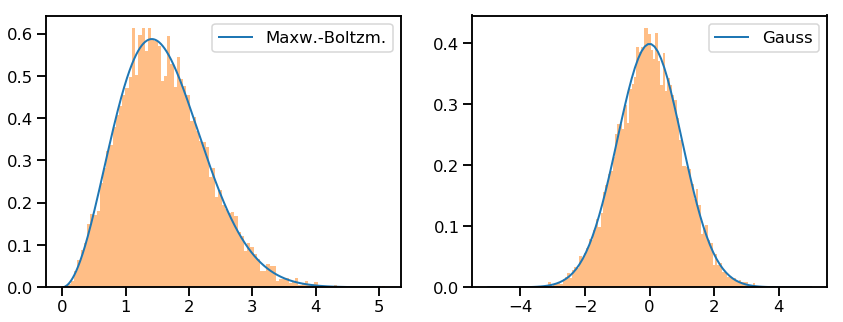

In [9]:
from scipy.stats import maxwell, norm
sigma = kB*T/m

def mb_velo(v):
    return  4*pi*(m/2/pi/kB/T)**(3/2)*v**2*np.exp(-(m*v**2/2/kB/T))

def normal_velo(v):
    return 1/np.sqrt(2*pi*sigma**2)*np.exp(-(v**2)/2/sigma**2)

v = np.linspace(0,5,int(1e4))
pv_mb = mb_velo(v)

v_long = np.linspace(-5,5,100)
pv_n = normal_velo(v_long)

r = maxwell.rvs(loc=0, scale=sigma, size=int(1e4))
n = norm.rvs(loc=0, scale=sigma, size=int(1e4))

sns.set_context("talk", rc={"lines.linewidth": 2})
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(14, 5))

ax0.plot(v, pv_mb, label='Maxw.-Boltzm.')
ax1.plot(v_long, pv_n, label='Gauss')

ax0.hist(r, density=True, histtype='stepfilled', alpha=0.5, bins=100)
ax1.hist(n, density=True, histtype='stepfilled', alpha=0.5, bins=100)

ax0.legend()
ax1.legend()
plt.show()

In [10]:
#MAXWELL-BOLTZMANN or GAUSSIAN
v = norm.rvs(size=NumOfTrajs)
# v = maxwell.rvs(size=NumOfTrajs)
# v[v<0] *= -1
# v += 20

### Underdamped
$m \ddot x = -\gamma \dot x(t) + \epsilon(t)$


or coupled single order O/SDE


$\dot x = v(t)$

$ \dot v = -\frac{\gamma}{m}  v(t) + \epsilon(t)$

Discretized:

$ x(t + dt) = x(t) + v(t) dt $

$ v(t + dt) = v(t) -\frac{\gamma}{m} v(t) dt + \epsilon(t)$

In [11]:
@jit(nopython=True, parallel=True)
def underdamped_step( vec ):
    x,v = vec
    dW = random.gauss(Mean, Var)
    dv = -v*dt + dW
    dx =  v*dt
    x += dx
    v += dv
    return x, v

@jit(nopython=True, parallel=True)
def underdamped_run( Traj ):
    Ntraj, Steps,_ = Traj.shape
    for run in prange(Ntraj):
        for i in range(Steps-1):
            Traj[run,i+1,:] = underdamped_step(Traj[run,i,:])
    return Traj

@jit(nopython=True, parallel=True)
def underdamped( Ntraj ):
    Traj = np.zeros( (Ntraj, Steps, 2), dtype=np.single)    
    Traj[:,0,0] = x  # set starting points
    Traj[:,0,1] = v  # set starting velocities 
    Traj = underdamped_run(Traj)
    return Traj

In [12]:
underdamped_trajs = underdamped(NumOfTrajs)
underdamped_trajs = underdamped_trajs[:,:,0]

In [13]:
trajs = (overdamped_trajs, underdamped_trajs)

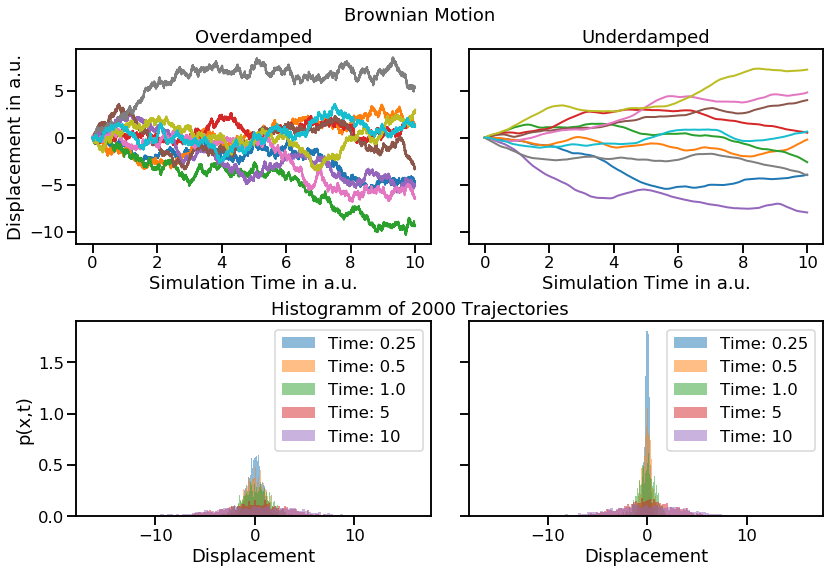

In [14]:
sns.set_context("talk", rc={"lines.linewidth": 2})
fig, axes = plt.subplots(2,2,figsize=(12, 8), sharex='row', sharey='row')

for ((ax0, ax1), traj) in zip(axes.T, trajs):
    for row in traj[:10]:
        ax0.plot(tsteps,row)


    for timepoint in (.25, .5, 1., 5, 10):
        step = int(Steps/t*timepoint-1)
        ax1.hist(traj[:,step], density=True, bins=100, orientation='vertical', alpha=0.5, label='Time: '+str(timepoint))

    
    ax1.legend()
    
ax = axes[0,0]
ax.set_ylabel('Displacement in a.u.')
for ax in axes[0]:
    ax.set_xlabel('Simulation Time in a.u.')

ax = axes[1,0]
ax.set_ylabel("p(x,t)")
for ax in axes[1]:
    ax.set_xlabel("Displacement")

axes[0,0].set_title('Overdamped')
axes[0,1].set_title('Underdamped')

fig.text(0.5, 0.47, 'Histogramm of {} Trajectories'.format(NumOfTrajs), ha='center')
fig.text(0.5, 0.98, 'Brownian Motion', ha='center')

plt.tight_layout()
plt.show()

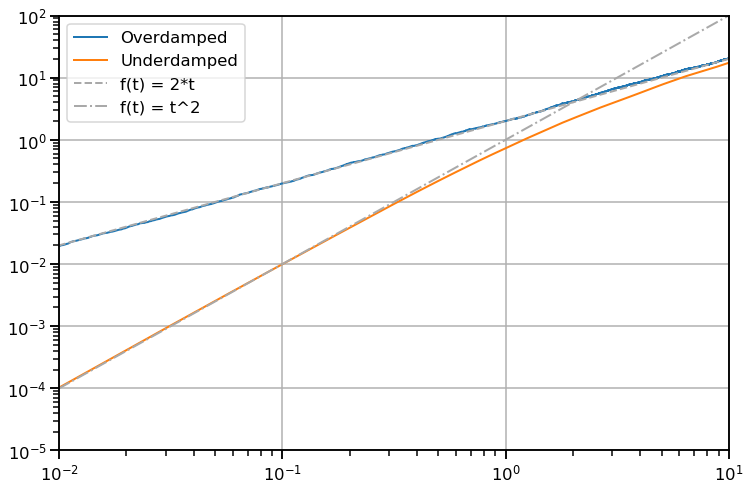

In [23]:
sns.set_context("talk", rc={"lines.linewidth": 2})
fig, axes = plt.subplots(1,1,figsize=(12, 8))

for traj, label in zip(trajs, ('Overdamped','Underdamped')):
    plt.plot(tsteps,np.mean(traj**2, axis=0), label=label)

xrange = np.arange(Steps)
plt.plot(tsteps, tsteps*2, '--', c='darkgrey', label='f(t) = 2*t')
plt.plot(tsteps, tsteps**2, '-.', c='darkgrey', label='f(t) = t^2')


axes.set_xscale('log')
axes.set_yscale('log')

axes.set_xlim(1e-2,1e1)
axes.set_ylim(1e-5,1e2)
plt.legend()
plt.grid()

In [16]:
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

In [17]:
traj = trajs[0][:100]

# histogram our data with numpy
n, bins = np.histogram(traj[:,0], 100, density=True)

# get the corners of the rectangles for the histogram
left = np.array(bins[:-1])
right = np.array(bins[1:])
bottom = np.zeros(len(left))
top = bottom + n
nrects = len(left)

nverts = nrects * (1 + 3 + 1)
verts = np.zeros((nverts, 2))
codes = np.ones(nverts, int) * path.Path.LINETO
codes[0::5] = path.Path.MOVETO
codes[4::5] = path.Path.CLOSEPOLY
verts[0::5, 0] = left
verts[0::5, 1] = bottom
verts[1::5, 0] = left
verts[1::5, 1] = top
verts[2::5, 0] = right
verts[2::5, 1] = top
verts[3::5, 0] = right
verts[3::5, 1] = bottom
patch = None

def animate(i):
    n, bins = np.histogram(traj[:,i], 100, density=True)
    top = bottom + n
    verts[1::5, 1] = top
    verts[2::5, 1] = top
    return [patch, ]

fig, ax = plt.subplots()
barpath = path.Path(verts, codes)
patch = patches.PathPatch(barpath, facecolor='orange', edgecolor='black', alpha=1)
ax.add_patch(patch)

ax.set_xlim(left[0], right[-1])
ax.set_ylim(bottom.min(), top.max())
plt.close()

anim = animation.FuncAnimation(fig, animate, frames=50, interval=200, repeat=False, blit=True)
HTML(anim.to_html5_video())

## Ornstein-Uhlenbeck Process

In [24]:
num_sims = 100000 ### display five runs
t_init = 0
t_end  = 5
N      = 1000 ### Compute 1000 grid points
dt     = float(t_end - t_init) / N 
y_init = 1.5
c_theta = 0.7
c_mu    = 0.
c_sigma = 0.06

ts    = np.arange(t_init, t_end, dt)

@jit(nopython=True, parallel=True)
def dW(delta_t): 
    return np.random.normal(loc = 0.0, scale = np.sqrt(delta_t))

@jit(nopython=True, parallel=True)
def ou_process():
    ys    = np.zeros((N, num_sims))
    ys[0,:] = np.random.random(num_sims)*2-1
    for k in prange(num_sims):
        for i in range(1, ts.size):
            t = (i-1) * dt
            y = ys[i-1,k]
            ys[i,k] = y + c_theta * (c_mu - y) * dt + c_sigma * dW(dt)
    return ys

In [25]:
ou_trajs = ou_process()

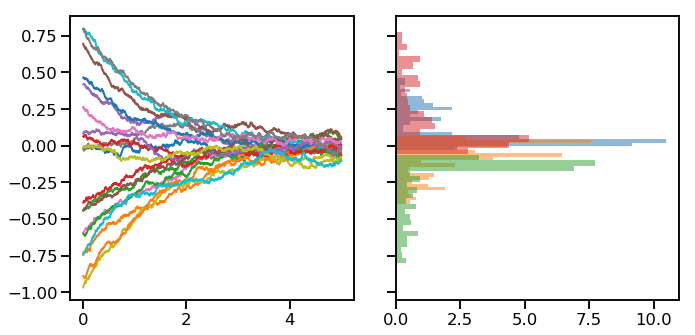

In [26]:
sns.set_context("talk", rc={"lines.linewidth": 2})
fig, axes = plt.subplots(1,2,figsize=(10, 5), sharey=True)
ax0, ax1 = axes

for y in ou_trajs.T[:20]:
    ax0.plot(ts, y)
for timepoint in (0, .1, .5, 1):
    step = int(N*timepoint-1)
    ax1.hist(ou_trajs[:,step], density=True, bins=20, orientation='horizontal', alpha=0.5, label='Time: '+str(timepoint))

plt.tight_layout()
plt.show()